In [6]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, Trainer, TrainingArguments, RobertaConfig, RobertaTokenizer, RobertaForSequenceClassification, BertTokenizer
from load_data import *
import re

class RE_Dataset(torch.utils.data.Dataset):
  """ Dataset 구성을 위한 class."""
  def __init__(self, pair_dataset, labels):
    self.pair_dataset = pair_dataset
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: val[idx].clone().detach() for key, val in self.pair_dataset.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

def preprocessing_dataset(dataset):
  """ 처음 불러온 csv 파일을 원하는 형태의 DataFrame으로 변경 시켜줍니다."""
  subject_entity = []
  object_entity = []
  for i,j in zip(dataset['subject_entity'], dataset['object_entity']):
    i = i[1:-1].split(',')[0].split(':')[1]
    j = j[1:-1].split(',')[0].split(':')[1]

    subject_entity.append(i)
    object_entity.append(j)
  out_dataset = pd.DataFrame({'id':dataset['id'], 'sentence':dataset['sentence'],'subject_entity':subject_entity,'object_entity':object_entity,'label':dataset['label'],})
  return out_dataset

def load_data(dataset_dir):
  """ csv 파일을 경로에 맡게 불러 옵니다. """
  pd_dataset = pd.read_csv(dataset_dir)
  dataset = preprocessing_dataset(pd_dataset)
  
  return dataset


In [127]:
train_dataset = load_data("../dataset/train/train.csv")
test_dataset = load_data("../dataset/test/test_data.csv")

train_dataset.head()

,id,sentence,subject_entity,object_entity,label
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,'비틀즈','조지 해리슨',no_relation
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,'민주평화당','대안신당',no_relation
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,'광주FC','한국프로축구연맹',org:member_of
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,'아성다이소','박정부',org:top_members/employees
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,'요미우리 자이언츠','1967',no_relation


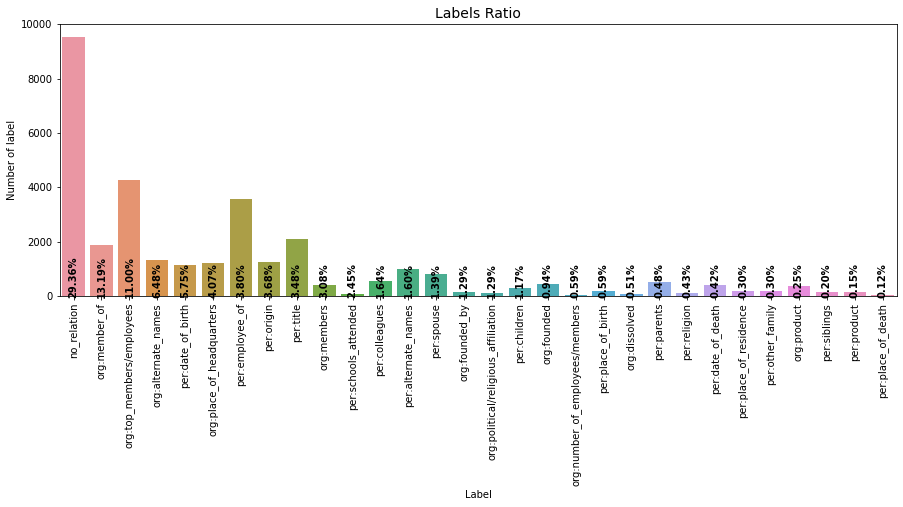

In [8]:
plt.figure(figsize=(15, 5)) 
ax = sns.countplot(x = 'label', data = train_dataset)

plt.xticks(np.arange(30), list(train_dataset.label.unique()), rotation = 90)
plt.title('Labels Ratio',fontsize= 14)
plt.xlabel('Label')
plt.ylabel('Number of label')

counts = train_dataset['label'].value_counts()
counts_pct = [f'{elem * 100:.2f}%' for elem in counts / counts.sum()]
for i, v in enumerate(counts_pct):
    ax.text(i, 0, v, horizontalalignment = 'center', rotation = 90, size = 10, color = 'black', fontweight = 'bold')
    
plt.show()

In [9]:
def label_to_num(label):
    num_label = []
    with open('dict_label_to_num.pkl', 'rb') as f:
        dict_label_to_num = pickle.load(f)
    for v in label:
        num_label.append(dict_label_to_num[v])
  
    return num_label

def tokenized_non_paddig(dataset, tokenizer):
    """ tokenizer에 따라 sentence를 tokenizing 합니다."""
    concat_entity = []
    for e01, e02 in zip(dataset['subject_entity'], dataset['object_entity']):
        temp = ''
        temp = e01 + '[SEP]' + e02
        concat_entity.append(temp)
    tokenized_sentences = tokenizer(
        concat_entity,
        list(dataset['sentence']),
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=256,
        add_special_tokens=True,
        )
    return tokenized_sentences

In [10]:
MODEL_NAME = "xlm-roberta-large"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenized_train = tokenized_non_paddig(train_dataset, tokenizer)
train_label = label_to_num(train_dataset['label'].values)
RE_train_dataset = RE_Dataset(tokenized_train, train_label)

/opt/conda/envs/basic/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


In [11]:
data_length = [len([tok for tok in sent if tok != tokenizer.pad_token_id]) for sent in tokenized_train['input_ids']]

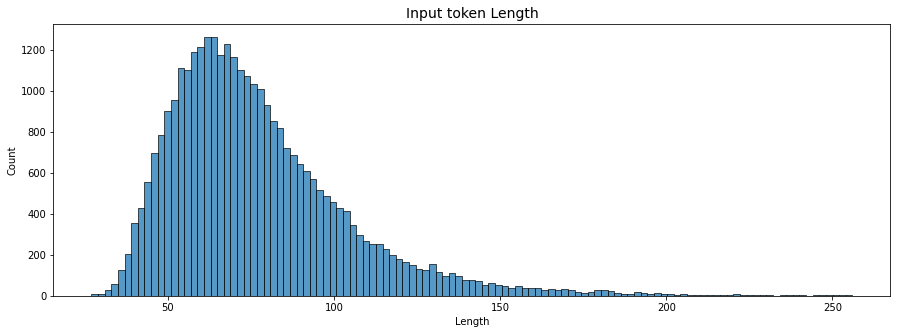

In [12]:
plt.figure(figsize=(15, 5)) 
ax = sns.histplot(data = data_length)

plt.title('Input token Length',fontsize= 14)
plt.xlabel('Length')
plt.ylabel('Count')

plt.show()

In [138]:
def special_lang_idx(dataset):
    df = dataset[['subject_entity', 'object_entity']]
    df = df.applymap(lambda x : re.sub('[a-zA-Zㄱ-ㅎ가-힣0-9 ]', '', x))
    # com = re.compile('\w+')
    # df = df.applymap(lambda x : "".join(com.findall(x)))
    df = df.applymap(lambda x : "".join(re.findall('\w', x)))
    df = df.applymap(lambda x : re.sub('\s', '', x))
    df.replace('', np.nan, inplace=True)
    
    special_lang_idx = []

    special_lang_idx.extend(list(df[df.notnull()['subject_entity']==True].index))
    special_lang_idx.extend(list(df[df.notnull()['object_entity']==True].index))

    special_lang_idx = list(set(special_lang_idx))

    return special_lang_idx



In [139]:
trn_special_lang_idx = special_lang_idx(train_dataset)
tst_special_lang_idx = special_lang_idx(test_dataset)
print("num of special lang in the obj&sub of Train set :", len(trn_special_lang_idx))
print("num of special lang in the obj&sub of Test set :", len(tst_special_lang_idx))

num of special lang in the obj&sub of Train set : 215
num of special lang in the obj&sub of Test set : 56


In [143]:
trn_spc_lang = train_dataset.iloc[trn_special_lang_idx].head()

,id,sentence,subject_entity,object_entity,label
22016,22016,능은 경기도 화성시에 위치한 융릉(隆陵)으로 남편인 장조와 함께 묻혀 있으며 인근에...,'효의왕후','건릉(健陵)',no_relation
5634,5634,"토레 안드레 플로(Tore André Flo, 1973년 6월 15일, 송노피오라네...",'토레 안드레 플로','Tore André Flo',per:alternate_names
19458,19458,"윤종신(尹鍾信, 1969년 10월 15일 ~)은 대한민국의 작곡가, 가수 겸 방송인이다.",'윤종신','尹鍾信',per:alternate_names
6667,6667,"최창권(崔彰權, 천주교 세례명 바오로, 1934년 10월 26일 ~ 2008년 1월...",'최창권','崔彰權',per:alternate_names
22028,22028,한편 복녕군은 고종 즉위 후인 1864년(고종 원년) 음력 7월 9일 효헌(孝獻)의...,'복녕군','효헌(孝獻)',per:alternate_names


In [144]:
t_spc_lang = test_dataset.iloc[tst_special_lang_idx].head()

In [ ]:
plt.figure(figsize=(15, 5)) 
ax = sns.countplot(x = 'label', data = train_dataset)

plt.xticks(np.arange(30), list(train_dataset.label.unique()), rotation = 90)
plt.title('Labels Ratio',fontsize= 14)
plt.xlabel('Label')
plt.ylabel('Number of label')

counts = train_dataset['label'].value_counts()
counts_pct = [f'{elem * 100:.2f}%' for elem in counts / counts.sum()]
for i, v in enumerate(counts_pct):
    ax.text(i, 0, v, horizontalalignment = 'center', rotation = 90, size = 10, color = 'black', fontweight = 'bold')
    
plt.show()